# scRNAseq Analysis
# NORMALIZATION - FEATURES SELECTION - DIM. REDUCTION - INTEGRATION - CLUSTERIZATION

> **CONDA ENV:** scrnaseq_workflow e scRNA_NEW

### **Manual cluster curation workflow (integration → annotation → cell removal)**

This section explains the workflow starting from **data integration and clustering**, followed by **manual annotation**, and finally **targeted removal of unwanted clusters**.

The first step is the `IntegraEtc` function. It is applied directly to the **QC-filtered AnnData object** (H5ad file) generated in the previous quality control steps. This function performs normalization, selection of highly variable genes, PCA, neighborhood graph construction, UMAP embedding, batch correction with Harmony, and Leiden clustering across **multiple resolutions**. As output, it provides several clustering options (e.g. `leiden_res0.6`, `leiden_res1.0`, `leiden_res1.5`, etc.), allowing the user to explore the data structure at different granularities.

Next comes the **annotation step** (referred to as step 5: annotation). At this stage, the user inspects the UMAPs and cluster compositions, assigns biological identities to clusters, and decides which populations are biologically relevant for the analysis. In this specific case, the dataset represents **intestinal epithelial cells**, and the goal is to remove clusters corresponding to **immune cell contamination** that remain after QC.

Once the clusters to be excluded are identified (for example, cluster `14` at a given Leiden resolution), the pipeline extracts the corresponding cell barcodes from the integrated object. These cells are then passed to the `UpdateCellsToRemove` function, which records the removal decision and maintains a cumulative list of all cells marked for exclusion across iterations.

The original QC-filtered AnnData object is then reloaded, all marked cells are removed in a single filtering step, and the cleaned dataset is **re-integrated and re-clustered from scratch** using `IntegraEtc`.

Finally, the dataset is **annotated again**, and this exclusion process can be repeated as many times as needed if additional unwanted clusters or low-quality cell populations are identified. 


In [2]:
out_dir='/media/tahila/DADOS/HD/2509-scRNA-seq_Hcar/03.analises_cellbender_fpr0.005/0.3.6.Sexta_rodada_QC'

# FUNCTIONS AND PACKAGES

In [ ]:
import os
import scanpy as sc
import scanpy.external as sce
import anndata as ad


import numpy as np
import pandas as pd

#sc.set_figure_params(dpi=100, facecolor="white")  # em vez de sc.settings.set_figure_params(...)
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [ ]:
def IntegraEtc(
    adata,
    input_layer="QC_filtered",
    n_pcs=30,
    n_neighbors=15,
    resolutions=None,
):
    """
    Perform normalization, feature selection, dimensionality reduction,
    batch integration, clustering, and visualization for scRNA-seq data.

    This function:
    - Uses a specified layer as input
    - Computes PCA and UMAP before and after batch integration (Harmony)
    - Runs Leiden clustering at multiple resolutions
    - Plots UMAPs colored by cluster assignments
    """

    # Default Leiden resolutions if none are provided
    if resolutions is None:
        resolutions = [0.6, 0.8, 1.0, 1.5, 2.0]

    # Use the selected layer as the active expression matrix
    adata.X = adata.layers[input_layer].copy()

    # Library-size normalization and log-transformation
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    # Store log-transformed data as a separate layer
    adata.layers[f"{input_layer}_log1p"] = adata.X.copy()

    # Highly variable gene selection (Seurat flavor), accounting for batches
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=2000,
        flavor="seurat",
        batch_key="sample",
    )

    # Principal component analysis
    sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack")

    # Compute neighborhood graph and UMAP using the raw PCA space
    sc.pp.neighbors(
        adata,
        n_neighbors=n_neighbors,
        n_pcs=n_pcs,
        use_rep="X_pca",
    )
    sc.tl.umap(adata)

    # Batch integration using Harmony on the PCA representation
    sce.pp.harmony_integrate(adata, key="sample")

    # Recompute neighborhood graph and UMAP using Harmony-corrected PCs
    sc.pp.neighbors(
        adata,
        n_neighbors=n_neighbors,
        n_pcs=n_pcs,
        use_rep="X_pca_harmony",
    )
    sc.tl.umap(adata)

    # Run Leiden clustering for each requested resolution
    leiden_keys = []
    for res in resolutions:
        key = f"leiden_res{res:g}"  # e.g. 0.6 -> 'leiden_res0.6'
        sc.tl.leiden(
            adata,
            resolution=res,
            random_state=42,
            key_added=key,
        )
        leiden_keys.append(key)

    # Remove previously stored color palettes for Leiden clusters
    for key in adata.obs.columns:
        if key.startswith("leiden_res"):
            color_key = f"{key}_colors"
            if color_key in adata.uns:
                del adata.uns[color_key]

    # Plot UMAPs colored by Leiden clusters, in groups of three resolutions
    for i in range(0, len(leiden_keys), 3):
        cols = leiden_keys[i:i+3]
        sc.pl.umap(
            adata,
            color=cols,
            size=4,
            legend_loc="on data",
        )

    return adata


In [ ]:
def UpdateCellsToRemove(
    out_dir: str,
    original_file: str,     # Updates the file listing cells to remove and returns the full set of cells (previous + new).
    res: str,
    clusters_to_remove: list,
    cells_to_remove_now: list
):
    """
    Update and track cells marked for removal across iterations.

    This function:
    - Appends a new entry to a persistent text file (`cells_to_remove.txt`)
    - Logs the source file, Leiden resolution, clusters removed, and cell IDs
    - Reads all previous entries and aggregates the full set of cells to remove
    - Ensures no duplicated cell IDs in the final output
    """

    file = f'{out_dir}/cells_to_remove.txt'

    # If the file does not exist yet, create it and write the header
    if not os.path.exists(file):
        with open(file, "w") as f:
            f.write("Original file\tResolution\tClusters to remove\tCells\n")

    # Append a new line with the current removal information
    with open(f'{out_dir}/cells_to_remove.txt', "a") as f:
        f.write(
            f"{original_file}\t"
            f"{'leiden_res' + str(res)}\t"
            f"{','.join(clusters_to_remove)}\t"
            f"{','.join(cells_to_remove_now)}\n"
        )

    print(f"🔹 cells_to_remove_now: {len(cells_to_remove_now)}")

    # Read the existing file to recover all previously marked cells
    df_prev = pd.read_csv(f'{out_dir}/cells_to_remove.txt', sep="\t")
    cells_to_remove = []

    # Collect all cells listed in previous entries
    if "Cells" in df_prev.columns and not df_prev.empty:
        for prev_cells in df_prev["Cells"].dropna():
            cells = prev_cells.split(",")
            cells_to_remove.extend(cells)
            print(f"🔹 cells_to_remove_individual: {len(cells)}")

    # Remove duplicates while keeping unique cell identifiers
    cells_to_remove = set(cells_to_remove)
    print(f"🔹 cells_to_remove_all: {len(cells_to_remove)}")

    return cells_to_remove


## COMPLETE DATA

2025-12-09 16:44:33,478 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-09 16:44:36,236 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-09 16:44:36,355 - harmonypy - INFO - Iteration 1 of 10
2025-12-09 16:44:40,447 - harmonypy - INFO - Iteration 2 of 10
2025-12-09 16:44:44,482 - harmonypy - INFO - Iteration 3 of 10
2025-12-09 16:44:48,468 - harmonypy - INFO - Iteration 4 of 10
2025-12-09 16:44:52,564 - harmonypy - INFO - Iteration 5 of 10
2025-12-09 16:44:56,566 - harmonypy - INFO - Iteration 6 of 10
2025-12-09 16:45:00,700 - harmonypy - INFO - Iteration 7 of 10
2025-12-09 16:45:04,741 - harmonypy - INFO - Converged after 7 iterations
/tmp/ipykernel_636917/774058840.py:53: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


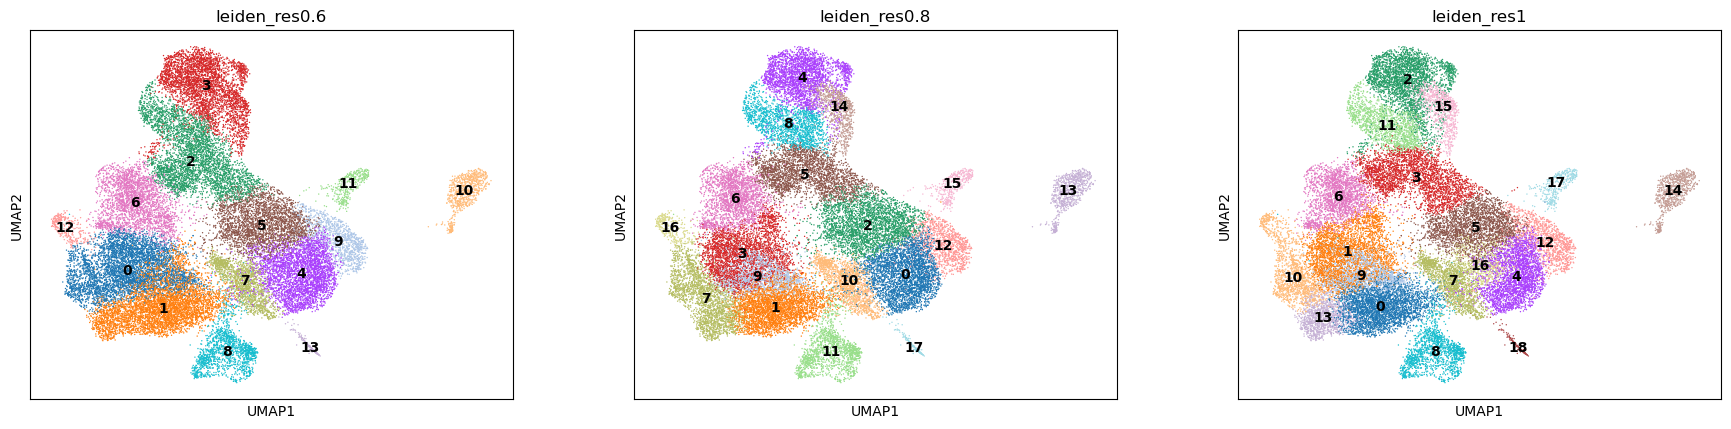

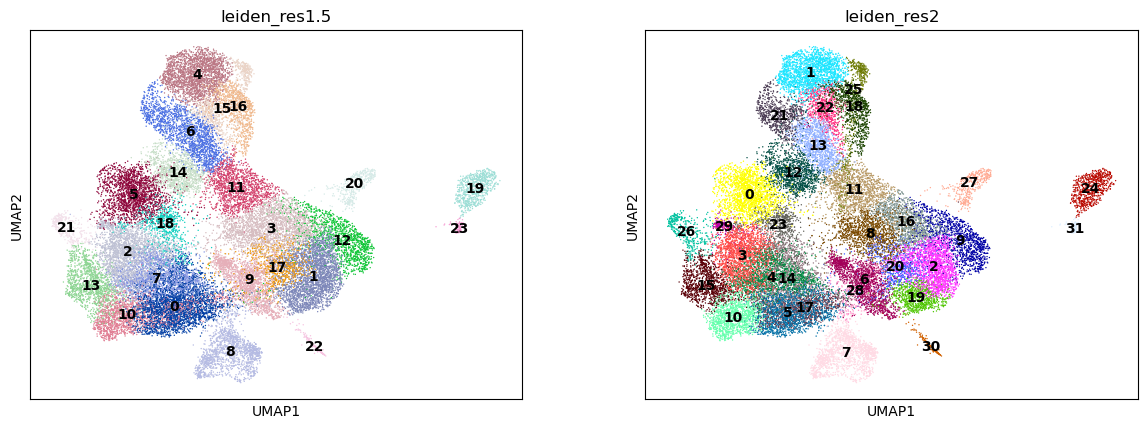

AnnData object with n_obs × n_vars = 31830 × 17042
    obs: 'sample', 'tissue', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet_thr0.2', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1', 'leiden_res1.5', 'leiden_res2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1', 'leiden_res1.5', 'leiden_res2', 'leiden_res0.6_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'leiden_res1.5_colors', 'leiden_res2_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'QC_filtered

In [ ]:
# Load the AnnData object generated after QC and filtering
adata = sc.read_h5ad(f"{out_dir}/0.3.6.QC6_filtered_matrix_filtered.h5ad")

# Run the integration and clustering pipeline:
# - Uses the specified input layer (QC-filtered counts)
# - Performs normalization, HVG selection, PCA, neighbors, and UMAP
# - Applies Harmony integration to correct for sample effects
# - Recomputes neighbors/UMAP on the harmonized space
# - Computes Leiden clustering at multiple resolutions (default list)
IntegraEtc(
    adata,
    input_layer="QC_filtered",
    n_pcs=35,
    n_neighbors=35,
)

# Save the integrated and clustered AnnData object for downstream analyses
adata.write(f"{out_dir}/04.8.Integrated-clustered_output_35.h5ad")

# Display the final AnnData object
adata


## EXCLUDING IMMUNE CLUSTER

Your filename has more than two extensions: ['.8', '.Integrated-clustered_output_35', '.h5ad'].
Only considering the two last: ['.Integrated-clustered_output_35', '.h5ad'].
Your filename has more than two extensions: ['.8', '.Integrated-clustered_output_35', '.h5ad'].
Only considering the two last: ['.Integrated-clustered_output_35', '.h5ad'].


adata integrado: (31830, 17042)
🔹 cells_to_remove_now: 770
🔹 cells_to_remove_individual: 770
🔹 cells_to_remove_individual: 1495
🔹 cells_to_remove_individual: 770
🔹 cells_to_remove_all: 2265
adata original: (31830, 17042)
adata filtrado: (29565, 17042)


2025-12-09 17:02:57,492 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-09 17:02:59,437 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-09 17:02:59,519 - harmonypy - INFO - Iteration 1 of 10
2025-12-09 17:03:03,415 - harmonypy - INFO - Iteration 2 of 10
2025-12-09 17:03:07,292 - harmonypy - INFO - Iteration 3 of 10
2025-12-09 17:03:11,167 - harmonypy - INFO - Iteration 4 of 10
2025-12-09 17:03:15,248 - harmonypy - INFO - Iteration 5 of 10
2025-12-09 17:03:18,918 - harmonypy - INFO - Iteration 6 of 10
2025-12-09 17:03:22,516 - harmonypy - INFO - Iteration 7 of 10
2025-12-09 17:03:26,040 - harmonypy - INFO - Converged after 7 iterations


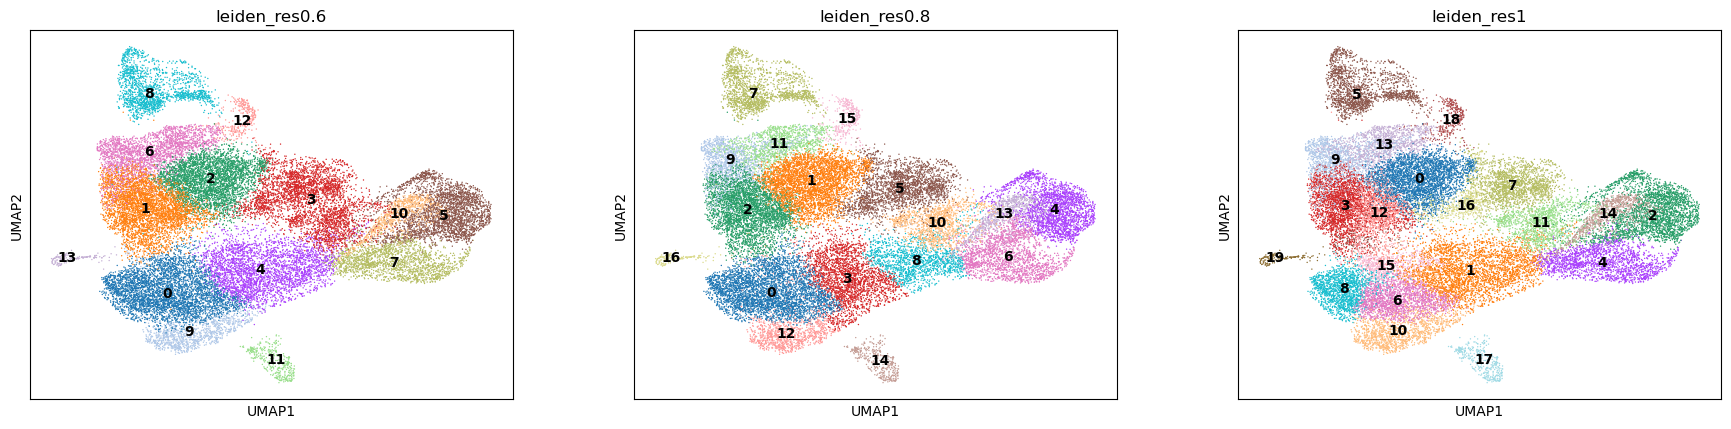

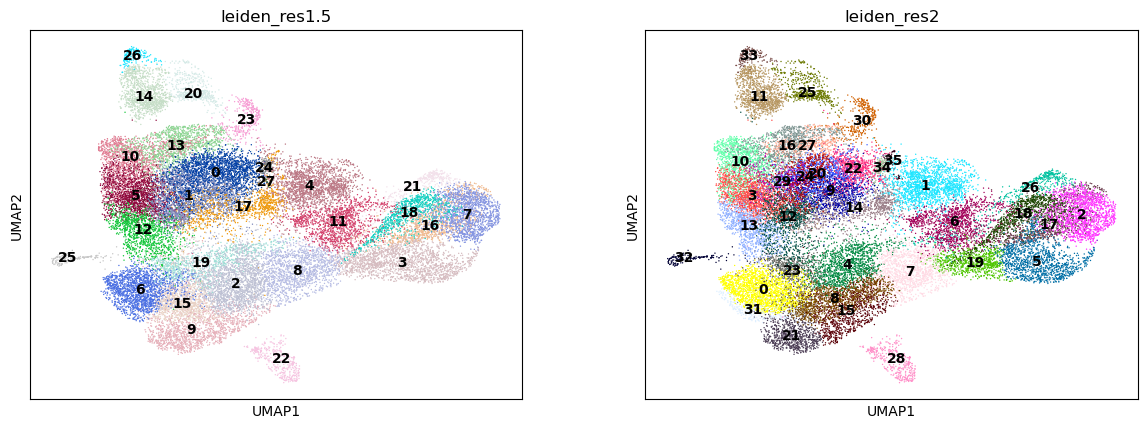

In [ ]:
# File name of the previously integrated and clustered AnnData
original_file = '04.8.Integrated-clustered_output_35.h5ad'

# Leiden resolution to use for cluster selection
res = 1

# List of cluster IDs to be removed at the chosen resolution
clusters_to_remove = ['14']

# Load the integrated AnnData object
adata_integrado = sc.read(f"{out_dir}/{original_file}")
print('adata integrado:', adata_integrado.shape)

# Identify cells belonging to the clusters marked for removal
cells_to_remove = adata_integrado.obs.index[
    adata_integrado.obs[f"leiden_res{res}"].isin(clusters_to_remove)
].tolist()

# Free memory from the integrated object
del adata_integrado

# Update (append) the global log of removed cells and retrieve
# the cumulative list of all cells marked for removal so far
cells_to_remove = UpdateCellsToRemove(
    out_dir,
    original_file,
    res,
    clusters_to_remove,
    cells_to_remove
)

# Reload the original QC-filtered (but not manually curated) AnnData
adata_original = sc.read_h5ad(f"{out_dir}/0.3.6.QC6_filtered_matrix_filtered.h5ad")
print('adata original:', adata_original.shape)

# Remove all cells flagged for exclusion
adata = adata_original[
    ~adata_original.obs_names.isin(cells_to_remove)
].copy()
print('adata filtrado:', adata.shape)

# Free memory from the original object
del adata_original

# Re-run integration and clustering on the curated dataset
IntegraEtc(adata)

# Save the new integrated AnnData after manual cluster exclusion
adata.write(f"{out_dir}/04.8.Integrated-clustered_output_35_exclImune.h5ad")
